In [59]:
import numpy as np
from astropy.io import fits
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from photoz_utils import *

In [62]:
def calculate_conv_outlier_rate(z_photo,z_spec):

# This function calculate the conventional outlier rate. 

    delz = abs(z_photo - z_spec)/(1+z_spec)
    number_outlier2 = len(np.where(abs(delz)>0.15))
    number_outlier = len(np.where(abs(delz)>0.15)[0])
    outlier_rate_conv = number_outlier/len(z_photo)
    return outlier_rate_conv

In [53]:
def calculate_outlier(photoz,y_test_original):
    outlier_index = []
    cat_outlier_index = []
    outliers = []
    photoz = np.array(photoz)
    y_test_original = np.array(y_test_original)
    for i in range(0,len(photoz)):


        outliers.append(abs(photoz[i] - y_test_original[i])/(1+y_test_original[i]))

        if outliers[i] > 0.15:
                outlier_index.append(i)


        if outliers[i] > 1:
                cat_outlier_index.append(i)



    print("number of outliers: ", len(outlier_index), " out of ", len(y_test_original))
    print("% of outliers: ", 100.0*len(outlier_index)/len(y_test_original))
    print("number of catastrophic outliers: ", len(cat_outlier_index), " out of ", len(y_test_original))
    print("% of catastrophic outliers: ", len(cat_outlier_index)/len(y_test_original))


In [5]:
def calculate_biweight_outlier_rate(z_photo,z_spec,b_bw,sigma_bw):
    
# The biweight outlier rate defined in HSC DPR2 paper. 

    delz = (z_photo - z_spec)/(1+z_spec)
    number_outlier = len(np.where(abs(delz-b_bw)>2*sigma_bw)[0])
    outlier_rate_conv = number_outlier/len(z_photo)
    return outlier_rate_conv
    

In [6]:
def generate_pdf_random_forest(number_estimator,X_train,y_train,X_test):

#number_estimator is an integer for the number of estimators for the random forest model
#X_train is an array for training set of inputs
#y_train is an array for training set of true values
#X_test is an array for testing set for inputs
#the output of this function is the predictions of pdfs of the X_test.
#output is a N x number_estimator array, where N is the number of elements in X_test. 
    
    randomForest = RandomForestRegressor(n_estimators = number_estimator)
    randomForest.fit(X_train, y_train)
    
    predictions = []
    for i in range (number_estimator):
        predictions.append(
        np.array(
        randomForest.estimators_[i].predict(X_test)))
    
    predictions = np.asarray(predictions).T
    predictions = np.sort(predictions, axis = 1)
    
    return predictions

In [7]:
def calculate_PIT(predictions,true_value):

# predictions is a two dimentional array. Each row is a PDF for the estimation of redshift for a galaxy. 
# y_test is an array containing the true_value of redshift for all the galaxies. 
# the ouput of this function is a PIT distribution for all the PDFs. 

    PIT  = np.zeros(len(predictions))
    
    for i in range (len(predictions)):          
        PIT[i] = len(np.where(predictions[i]<true_value[i])[0])*1.0/len(predictions[0])
        
    return PIT

In [8]:
ls

 BB_gradientboostingregressor.ipynb
'BB_HSCPhoto-ZPrediction inXGBoost.ipynb'
'Binning SEDs by Redshift.ipynb'
 calculate_metrics.ipynb
 create_PIT.ipynb
 example_notebook_bayesian_regression.ipynb
 example_notebook_producing_nans.ipynb
'HSC Photo-Z Data and Simple Model Exploration.ipynb'
 imagez_utils.py
 limit_gals_per_redshift_bin-500-gridsearch-HSC_big.ipynb
 limit_gals_per_redshift_bin-500-HSC-big.ipynb
 look_at_data-HSC_big.ipynb
 Look_at_HSC_demp_photoz.ipynb
'Photo-Z Estimation in Mizuki.ipynb'
'Photo-Z Estimation in Random Forest.ipynb'
'Photo-Z Estimation in XGBoost.ipynb'
 photoz_utils.py
 RF_big_data.ipynb
'Tensorboard Test.ipynb'
 visualize_data.py


In [9]:
photozdata = pd.read_csv('/mnt/data/HSC/HSC_v3/all_specz_flag_forced_forced2_spec_z_matched_online.csv')

In [10]:
photozdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801246 entries, 0 to 801245
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   # object_id             801246 non-null  int64  
 1   specz_redshift_err      801246 non-null  float64
 2   specz_redshift          801246 non-null  float64
 3   specz_mag_i             794360 non-null  float64
 4   specz_name              801246 non-null  object 
 5   specz_ra                801246 non-null  float64
 6   specz_dec               801246 non-null  float64
 7   specz_flag_homogeneous  801246 non-null  bool   
 8   ra                      801246 non-null  float64
 9   dec                     801246 non-null  float64
 10  coord                   801246 non-null  object 
 11  skymap_id               801246 non-null  int64  
 12  g_cmodel_mag            801232 non-null  float64
 13  r_cmodel_mag            801244 non-null  float64
 14  i_cmodel_mag        

In [11]:
filt = (photozdata['specz_redshift'] < 4)\
& (photozdata['specz_redshift'] > 0.01)\
& (photozdata['specz_redshift_err'] > 0) \
& (photozdata['specz_redshift_err'] < 1)\
&(photozdata["specz_redshift_err"]<0.005*(1+photozdata["specz_redshift"]))\
&(photozdata['g_cmodel_mag'] >0)\
&(photozdata['r_cmodel_mag'] >0)\
&(photozdata['i_cmodel_mag'] >0)\
&(photozdata['z_cmodel_mag'] >0)\
&(photozdata['y_cmodel_mag'] >0)\
&(photozdata['g_cmodel_mag'] < 50)\
&(photozdata['r_cmodel_mag'] < 50)\
&(photozdata['i_cmodel_mag'] < 50)\
&(photozdata['z_cmodel_mag'] < 50)\
&(photozdata['y_cmodel_mag'] < 50)

photozdata_subset = photozdata[filt]

In [12]:
photozdata_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 759526 entries, 1 to 801245
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   # object_id             759526 non-null  int64  
 1   specz_redshift_err      759526 non-null  float64
 2   specz_redshift          759526 non-null  float64
 3   specz_mag_i             753613 non-null  float64
 4   specz_name              759526 non-null  object 
 5   specz_ra                759526 non-null  float64
 6   specz_dec               759526 non-null  float64
 7   specz_flag_homogeneous  759526 non-null  bool   
 8   ra                      759526 non-null  float64
 9   dec                     759526 non-null  float64
 10  coord                   759526 non-null  object 
 11  skymap_id               759526 non-null  int64  
 12  g_cmodel_mag            759526 non-null  float64
 13  r_cmodel_mag            759526 non-null  float64
 14  i_cmodel_mag        

In [13]:
y = photozdata_subset['specz_redshift']
X = photozdata_subset[['g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag','y_cmodel_mag']]

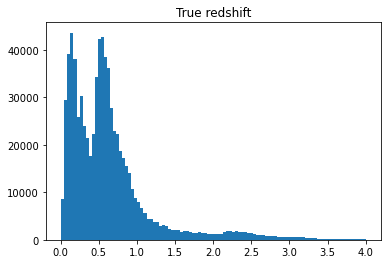

In [14]:
#plot the histogram of true redshift

plt.hist(y,bins = 100)
plt.title("True redshift")
plt.show()

In [55]:
X_train ,X_test,y_train,y_test = train_test_split(X,y,test_size=0.8)

In [56]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)

RandomForestRegressor()

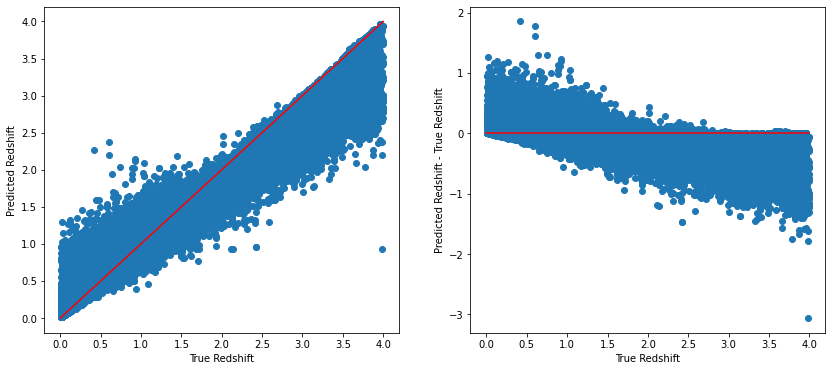

In [17]:
# look at how well the model predicts the traing data
y_train_predict = random_forest_model.predict(X_train)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(y_train,y_train_predict,'o')
plt.ylabel('Predicted Redshift')
plt.xlabel('True Redshift')
plt.plot([0,4], [0,4], color='red')
plt.subplot(1,2,2)
plt.plot(y_train,y_train_predict-y_train,'o')
plt.ylabel('Predicted Redshift - True Redshift')
plt.xlabel('True Redshift')
plt.plot([0,4], [0,0], color='red')


In [ ]:
random_forest_model.fit(X_test, y_test)

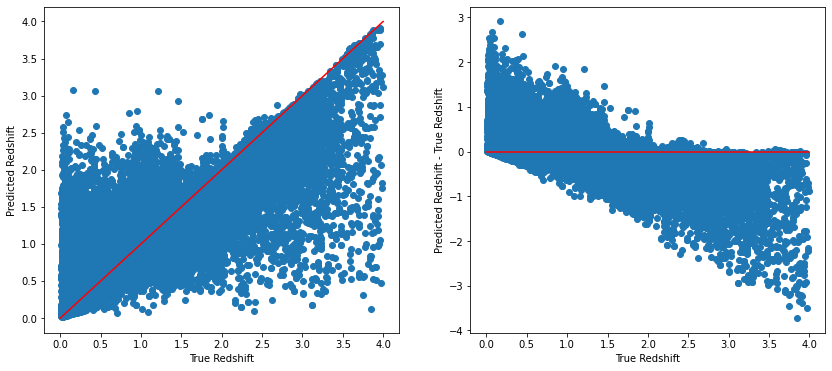

In [18]:
# look at how well the model predicts the traing data
y_test_predict = random_forest_model.predict(X_test)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(y_test,y_test_predict,'o')
plt.ylabel('Predicted Redshift')
plt.xlabel('True Redshift')
plt.plot([0,4], [0,4], color='red')
plt.subplot(1,2,2)
plt.plot(y_test,y_test_predict-y_test,'o')
plt.ylabel('Predicted Redshift - True Redshift')
plt.xlabel('True Redshift')
plt.plot([0,4], [0,0], color='red')


In [20]:
from scipy.stats import gaussian_kde
xy = np.vstack([y_test,y_test_predict])
z = gaussian_kde(xy)(xy)

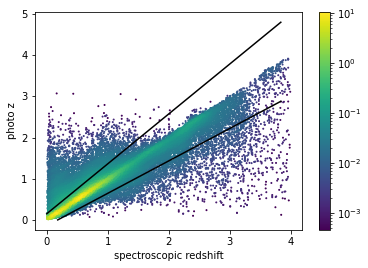

In [21]:
import matplotlib.cm as cm
import matplotlib
fig, ax = plt.subplots()
ax_ = ax.scatter(y_test, y_test_predict, c=z,s = 1,edgecolor=None, norm=matplotlib.colors.LogNorm())
plt.colorbar(ax_)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.18,1.6*2.4],[0,1.2*2.4], color='black')
plt.plot([0, 1.6 * 2.4], [.15, 2 * 2.4],color = 'black')

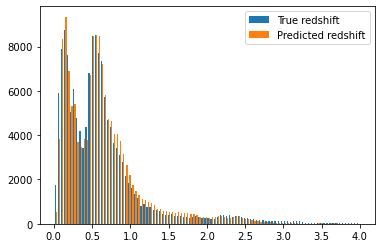

In [22]:
plt.figure()
plt.hist([y_test,y_test_predict],bins = 100)
plt.legend(["True redshift","Predicted redshift"])
plt.show()

In [63]:
b_bw = calculate_bias(y_train_predict,y_train)
sigma_bw = calculate_scatter(y_train_predict,y_train)
outlier_rate = calculate_biweight_outlier_rate(y_train_predict,y_train,b_bw,sigma_bw)
loss_function = calculate_loss(y_train_predict,y_train)
conv_outlier_rate = calculate_conv_outlier_rate(y_train_predict,y_train)


average_loss = sum(loss_function)/len(loss_function)


print ("bias: %s"%(b_bw))
print("scatter: %s"%(sigma_bw))
print("biweight outlier rate: %s"%(outlier_rate))
print("conventional outlier rate: %s"%(conv_outlier_rate))
print("average loss: %s"%(average_loss))

bias: 0.01000556713249591
scatter: 0.3781895623929108
biweight outlier rate: 0.07192159573417596
conventional outlier rate: 0.660776472137191
average loss: 0.6057570292796995


In [33]:
conv_outlier_rate, number_outlier_2 = calculate_conv_outlier_rate(y_test_predict,y_test)
print("conventional outlier rate: %s"%(conv_outlier_rate))


conventional outlier rate: 0.082116572090635


In [47]:
y_test_predict

array([0.5690775 , 0.65168336, 0.17721437, ..., 0.5339627 , 0.82590645,
       0.74279943])

In [54]:
calculate_outlier(y_test_predict,y_test)

number of outliers:  12474  out of  151906
% of outliers:  8.2116572090635
number of catastrophic outliers:  433  out of  151906
% of catastrophic outliers:  0.0028504469869524572


In [50]:
y_test

172875    0.564030
64798     0.677600
541804    0.156350
553271    0.243680
156834    0.369060
            ...   
2147      0.384230
167232    0.459840
47079     0.525710
799243    0.886854
649003    0.735076
Name: specz_redshift, Length: 151906, dtype: float64

In [34]:
number_outlier_2

1

In [64]:
b_bw = calculate_bias(y_test_predict,y_test)
sigma_bw = calculate_scatter(y_test_predict,y_test)
outlier_rate = calculate_biweight_outlier_rate(y_test_predict,y_test,b_bw,sigma_bw)
loss_function = calculate_loss(y_test_predict,y_test)
conv_outlier_rate = calculate_conv_outlier_rate(y_test_predict,y_test)


average_loss = sum(loss_function)/len(loss_function)


print ("bias: %s"%(b_bw))
print("scatter: %s"%(sigma_bw))
print("biweighht outlier rate: %s"%(outlier_rate))
print("conventional outlier rate: %s"%(conv_outlier_rate))
print("average loss: %s"%(average_loss))

bias: 0.020482931415491838
scatter: 0.3832316379702585
biweighht outlier rate: 0.06663989572498782
conventional outlier rate: 0.6649836082840704
average loss: 0.6080844622454419


In [126]:
#predictions = generate_pdf_random_forest(100,X_train,y_train,X_test)

In [139]:
#y_test = np.asarray(y_test)

In [141]:
#PIT = calculate_PIT(predictions,y_test)

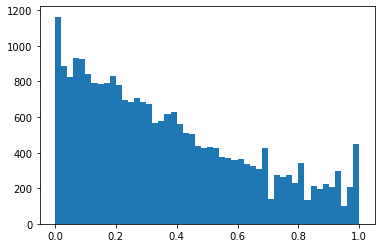

In [144]:
#plt.hist(PIT,bins = 50)
#plt.show()